In [10]:
import numpy as np
import glob
import os
from opac_mixer.read import ReadOpacChubb
from opac_mixer.emulator import Emulator

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown
%matplotlib widget

In [11]:
R='S1'
base = f'{os.environ["pRT_input_data_path"]}/opacities/lines/corr_k'
files = glob.glob(os.path.join(base,f'*_R_{R}/*.h5'))
batchsize = int(2**19)

load = True
load_model = False

In [12]:
opac = ReadOpacChubb(files)
emulator = Emulator(opac)

In [13]:
emulator.setup_sampling_grid(batchsize=batchsize, filename=f'data/input_{batchsize}', load=load)
emulator.setup_mix(filename=f'data/mix_R_{R}_{batchsize}', load=load)
emulator.setup_model(load=load_model, filename=f'data/model_R_{R}_{batchsize}', tree_method='hist')
emulator.fit()

[0]	validation_0-rmse:0.23049	validation_1-rmse:0.23006
[1]	validation_0-rmse:0.19101	validation_1-rmse:0.19068
[2]	validation_0-rmse:0.16064	validation_1-rmse:0.16039
[3]	validation_0-rmse:0.13644	validation_1-rmse:0.13625
[4]	validation_0-rmse:0.11825	validation_1-rmse:0.11812
[5]	validation_0-rmse:0.10368	validation_1-rmse:0.10360
[6]	validation_0-rmse:0.09245	validation_1-rmse:0.09241
[7]	validation_0-rmse:0.08356	validation_1-rmse:0.08356
[8]	validation_0-rmse:0.07640	validation_1-rmse:0.07642
[9]	validation_0-rmse:0.07001	validation_1-rmse:0.07007
[10]	validation_0-rmse:0.06500	validation_1-rmse:0.06508
[11]	validation_0-rmse:0.06090	validation_1-rmse:0.06099
[12]	validation_0-rmse:0.05783	validation_1-rmse:0.05794
[13]	validation_0-rmse:0.05495	validation_1-rmse:0.05507
[14]	validation_0-rmse:0.05256	validation_1-rmse:0.05268
[15]	validation_0-rmse:0.05056	validation_1-rmse:0.05070
[16]	validation_0-rmse:0.04885	validation_1-rmse:0.04900
[17]	validation_0-rmse:0.04731	validation

In [14]:
y_predict_test = emulator.predict(emulator.X_test, shape='same')
y_predict_test_scaled = emulator.output_scaling(y_predict_test)
print('r2score on test:', r2_score(y_true=emulator.y_test, y_pred=y_predict_test))
print('mean squared error on test:', np.sqrt(mean_squared_error(y_true=emulator.y_test, y_pred=y_predict_test)))

print('r2score on scaled test:', r2_score(y_true=emulator.output_scaling(emulator.y_test), y_pred=y_predict_test_scaled))
print('mean absolute error on scaled test:', np.sqrt(mean_squared_error(y_true=emulator.output_scaling(emulator.y_test), y_pred=y_predict_test_scaled)))

r2score on test: 0.9160857846263676
mean squared error on test: 3.406805793523707
r2score on scaled test: 0.9862515646442069
mean absolute error on scaled test: 0.025487041785341332


In [15]:
y_predict_train = emulator.predict(emulator.X_train, shape='same')
y_predict_train_scaled = emulator.output_scaling(y_predict_train)
print('r2score on train:', r2_score(y_true=emulator.y_train, y_pred=y_predict_train))
print('mean squared error on train:', np.sqrt(mean_squared_error(y_true=emulator.y_train, y_pred=y_predict_train)))

print('r2score on scaled train:', r2_score(y_true=emulator.output_scaling(emulator.y_train), y_pred=y_predict_train_scaled))
print('mean absolute error on scaled train:', np.sqrt(mean_squared_error(y_true=emulator.output_scaling(emulator.y_train), y_pred=y_predict_train_scaled)))

r2score on train: 0.9327967469362661
mean squared error on train: 2.9024012729371673
r2score on scaled train: 0.9869845172377655
mean absolute error on scaled train: 0.024863021505997267


In [16]:
y_predict = {'test': emulator.reshape(y_predict_test), 'train': emulator.reshape(y_predict_train)}
y_true = {'test':emulator.reshape(emulator.y_test), 'train': emulator.reshape(emulator.y_train)}

interactive(children=(FloatSlider(value=0.0, description='index_frac', max=0.99, step=0.05), Dropdown(descript…

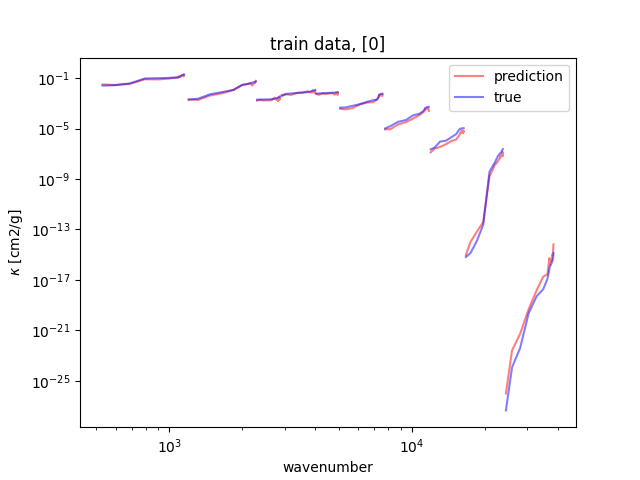

In [17]:
fig_tes, ax_tes = plt.subplots(1,1)
def plot_single_prediction(index_frac, mode):
    ax_tes.cla()
    index = np.array([int(index_frac*len(y_predict[mode]))])
    for fi in range(y_predict[mode].shape[1]):
        x = opac.bin_edges[fi]+opac.weights.cumsum()*(opac.bin_edges[fi+1]-opac.bin_edges[fi])
        lp, = ax_tes.loglog(x,y_predict[mode][index][0,fi,:], color ='red', alpha=0.5)
        lt, = ax_tes.loglog(x,y_true[mode][index][0,fi,:], color = 'blue', alpha=0.5)
        
    # ax_tes.set_yscale('linear')
    ax_tes.set_ylabel(r'$\kappa$ [cm2/g]')
    ax_tes.set_xlabel(r'wavenumber')
    ax_tes.set_title(f'{mode} data, {index}')
    ax_tes.legend([lp,lt],['prediction','true'])

interact(plot_single_prediction, index_frac=FloatSlider(min=0., max=.99, step=0.05, value=0.), mode=Dropdown(options=['train','test']));

interactive(children=(IntSlider(value=0, description='freqi', max=9), IntSlider(value=0, description='gi', max…

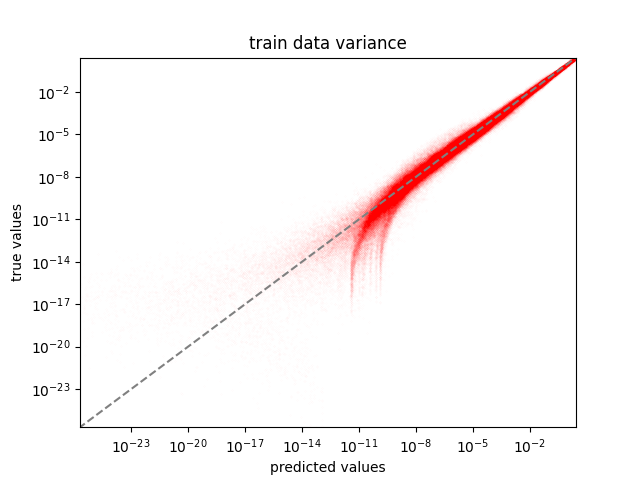

In [18]:
fig_t, ax_t = plt.subplots(1,1) 
lt, = ax_t.plot(y_predict['test'][:,0,0], y_true['test'][:,0,0], 'ro', ms=0.01, linestyle="None")
ax_t.set_xscale('log')
ax_t.set_yscale('log')
dt, = ax_t.plot([y_predict['test'][:,0,0].min(), y_predict['test'][:,0,0].max()], [y_predict['test'][:,0,0].min(), y_predict['test'][:,0,0].max()], color = 'gray', ls = '--')
ax_t.set_ylabel('true values')
ax_t.set_xlabel('predicted values')
    

def update_prediction_test(freqi, gi, mode):
    lt.set_ydata(y_true[mode][:,freqi,gi])
    lt.set_xdata(y_predict[mode][:,freqi,gi])    
    dt.set_ydata([y_predict[mode][:,freqi,gi].min(), y_predict[mode][:,freqi,gi].max()])
    dt.set_xdata([y_predict[mode][:,freqi,gi].min(), y_predict[mode][:,freqi,gi].max()])
    ax_t.set_xlim([y_true[mode][:,freqi,gi].min(),y_true[mode][:,freqi,gi].max()])
    ax_t.set_ylim([y_true[mode][:,freqi,gi].min(),y_true[mode][:,freqi,gi].max()])        
    ax_t.set_title(f'{mode} data variance')
    fig_t.canvas.draw_idle()


interact(update_prediction_test, freqi=IntSlider(min=0, max=opac.lf[0]-1, step=1, value=0),gi=IntSlider(min=0, max=opac.lg[0]-1, step=1, value=0), mode=Dropdown(options=['train','test']));